# 1. Загрузка и подготовка данных

Загрузим данные, посмотрим на них, если есть ненужные для обучения модели и построения выводов столбцы, удалим их
Разделим каждый файл geo_0, geo_1 and geo_2 на test и valid; test и valid разделим на features и target

In [1]:
import pandas as pd
import sklearn
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse

from numpy.random import RandomState
from sklearn.preprocessing import OneHotEncoder,LabelEncoder



In [2]:
#загружаем файлы
geo_0=pd.read_csv('/datasets/geo_data_0.csv')
geo_1=pd.read_csv('/datasets/geo_data_1.csv')
geo_2=pd.read_csv('/datasets/geo_data_2.csv')

# Проведем небольшой предварительный анализ

Посторим диаграммы и таблицы корреляции для каждого региона

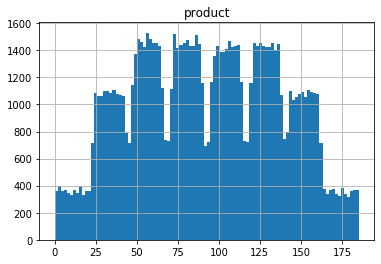

               f0        f1        f2   product
f0       1.000000 -0.440723 -0.003153  0.143536
f1      -0.440723  1.000000  0.001724 -0.192356
f2      -0.003153  0.001724  1.000000  0.483663
product  0.143536 -0.192356  0.483663  1.000000
                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        0.500419       0.250143       2.502647      92.500000
std         0.871832       0.504433       3.248248      44.288691
min        -1.408605      -0.848218     -12.088328       0.000000
25%        -0.072580      -0.200881       0.287748      56.497507
50%         0.502360       0.250252       2.515969      91.849972
75%         1.073581       0.700646       4.715088     128.564089
max         2.362331       1.343769      16.003790     185.364347


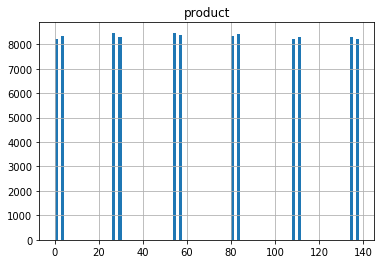

               f0        f1        f2   product
f0       1.000000  0.182287 -0.001777 -0.030491
f1       0.182287  1.000000 -0.002595 -0.010155
f2      -0.001777 -0.002595  1.000000  0.999397
product -0.030491 -0.010155  0.999397  1.000000
                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        1.141296      -4.796579       2.494541      68.825000
std         8.965932       5.119872       1.703572      45.944423
min       -31.609576     -26.358598      -0.018144       0.000000
25%        -6.298551      -8.267985       1.000021      26.953261
50%         1.153055      -4.813172       2.011479      57.085625
75%         8.621015      -1.332816       3.999904     107.813044
max        29.421755      18.734063       5.019721     137.945408


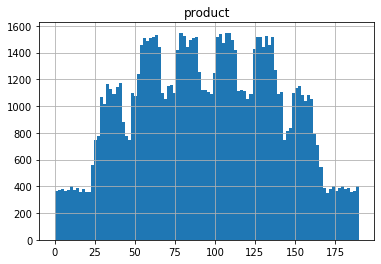

               f0        f1        f2   product
f0       1.000000  0.000528 -0.000448 -0.001987
f1       0.000528  1.000000  0.000779 -0.001012
f2      -0.000448  0.000779  1.000000  0.445871
product -0.001987 -0.001012  0.445871  1.000000
                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        0.002023      -0.002081       2.495128      95.000000
std         1.732045       1.730417       3.473445      44.749921
min        -8.760004      -7.084020     -11.970335       0.000000
25%        -1.162288      -1.174820       0.130359      59.450441
50%         0.009424      -0.009482       2.484236      94.925613
75%         1.158535       1.163678       4.858794     130.595027
max         7.238262       7.844801      16.739402     190.029838


In [3]:
for geo in [geo_0, geo_1,geo_2]:
    geo.hist(['product'],bins=100)
    plt.show()
    print(geo.corr())
    print(geo.describe())

Парочка интересных факторов:
1. Почти идеальная корреляция между f2 и product в регионе geo_1
2. Интервальное разбиение product-а в регионе geo_1: либо это ошибка в синтетических данных, а если данные были бы реальными, то это могло бы говорить о наличии в регионе крупного месторождения(вероятно, что f2-глубина залегания)
3. В целом регионы geo_0 и geo_2 похожи друг на друга: непрерывный спектр product-а, отсутствующая или низкая корреляция между f-ками и product-ом

In [4]:
#удаляем столбец id, так как его значение никак не может влиять на количество нефти в скважине
geo_0=geo_0.drop(['id'],axis=1)
geo_1=geo_1.drop(['id'],axis=1)
geo_2=geo_2.drop(['id'],axis=1)

In [5]:
#функция разделения на train и valid
def division(df):
    df_train, df_valid= train_test_split(df, test_size=0.25,random_state=12345)
    return df_train, df_valid
#функция разделения df на features и target
def feat_targ(df):
    target=df['product']
    features=df.drop(['product'],axis=1)
    return features, target



In [6]:
#получим train и valid для каждого файла
train_0, valid_0=division(geo_0)
train_1, valid_1=division(geo_1)
train_2, valid_2 = division(geo_2)
#разделим на features и target каждый train и valid
feat_tr_0, target_tr_0=feat_targ(train_0)
feat_val_0, target_val_0=feat_targ(valid_0)

feat_tr_1, target_tr_1=feat_targ(train_1)
feat_val_1,target_val_1=feat_targ(valid_1)

feat_tr_2, target_tr_2=feat_targ(train_2)
feat_val_2, target_val_2=feat_targ(valid_2)


# 2. Обучение и проверка модели

Обучим модель линейной регрессии, получим предсказания для каждого региона

In [7]:
def model_res(feat, target,feat_val, target_val,geo):
    model=LinearRegression()
    model.fit(feat,target)
    pred = model.predict(feat_val)
    rmse = mse(target_val,pred)**0.5
    
    print('RMSE', rmse)
    print('mean',pred.mean())
    
    return pd.Series(pred)



In [8]:
print('geo_0')
pred_0=model_res(feat_tr_0, target_tr_0, feat_val_0, target_val_0, geo_0)
print('geo_1')
pred_1=model_res(feat_tr_1, target_tr_1, feat_val_1,target_val_1,geo_1)
print('geo_2')
pred_2=model_res(feat_tr_2, target_tr_2,feat_val_2, target_val_2,geo_2)

geo_0
RMSE 37.5794217150813
mean 92.59256778438038
geo_1
RMSE 0.893099286775616
mean 68.728546895446
geo_2
RMSE 40.02970873393434
mean 94.96504596800489


In [9]:
print('Данные о распределении предсказанных объемов в каждом районе: geo_0, geo_1 и geo_2')
for pred in [pred_0, pred_1, pred_2]:
    print('')
    print(pd.Series(pred).describe())


Данные о распределении предсказанных объемов в каждом районе: geo_0, geo_1 и geo_2

count    25000.000000
mean        92.592568
std         23.176994
min         -9.367846
25%         76.652232
50%         92.661884
75%        108.437632
max        180.180713
dtype: float64

count    25000.000000
mean        68.728547
std         46.010225
min         -1.893774
25%         28.536661
50%         57.851586
75%        109.346485
max        139.818970
dtype: float64

count    25000.000000
mean        94.965046
std         19.853733
min         17.131597
25%         81.388500
50%         95.031204
75%        108.492663
max        165.856833
dtype: float64


Как видим, предпочтительного региона для добычи нефти нет, в одном районе есть отрицательные предсказанные значения вкупе с высоким максимальным и 75%, с другой стороны районе geo_2 выглядит предпочтительным: относительно высокое среднее, но при этом невысокое максимальное и 75% значения.Посчитаем риски, прибыль и выберем район для разработки

# 3. Подготовка к расчету прибыли

Посчитаем все необходимые данные для расчета ликвидности добычи нефти в районе 

In [10]:
budget = 10**10#суммарный бюджет в рублях 
budget_one_well=budget/200 #бюджет на каждую вышку
print('Бюджет на разработку одной вышки в  рублях',budget_one_well)
profit_one_barr=450000#стоимость одной тысячи баррелей нефти
min_volume_oil= budget_one_well/profit_one_barr
print('Средний объем нефти(в тыс баррелях) в каждой скважине для выхода "в ноль" ',min_volume_oil)


Бюджет на разработку одной вышки в  рублях 50000000.0
Средний объем нефти(в тыс баррелях) в каждой скважине для выхода "в ноль"  111.11111111111111


# 4. Расчёт прибыли и рисков 

Воспользуемся методом Bootstrap для более точной статистической оценки привлекательности каждого региона

In [11]:
#функция считающая прибыль для 200 самых выполненных вышек
def profitability(target, probabilities):
    probs_sorted = probabilities.sort_values(ascending=False)
    selected = target[probs_sorted.index][:200]
    product = selected.sum()
    revenue = product * profit_one_barr
    return revenue - budget

In [12]:
state = np.random.RandomState(12345)
#bootstrap
def bootstrap(target, probabilities):
    values = []
    for i in range(1000):
        target_subsample = target.sample(n=500, replace=True, random_state=state)
        probs_subsample = pd.Series(probabilities[target_subsample.index])
        values.append(profitability(target, probs_subsample))
    values = pd.Series(values)
    lower = values.quantile(0.05) 
    upper = values.quantile(0.95)
    
    return (print('Все данные в млн рублей'),
            print('Нижняя граница ', "{:.2f}".format(lower/1000000)), print('Верхняя граница',"{:.2f}".format(upper/1000000)), 
            print('Среднее значение прибыли ',"{:.2f}".format(values.mean()/1000000)),

            print('Риск в %', (values < 0).mean()* 100, "%"))    
        
        

In [13]:
print('geo_0')
bootstrap(target_val_0.reset_index(drop=True),pred_0)


geo_0
Все данные в млн рублей
Нижняя граница  -37.18
Верхняя граница 842.69
Среднее значение прибыли  396.16
Риск в % 6.9 %


(None, None, None, None, None)

In [14]:
print('geo_1')
print(bootstrap(target_val_1.reset_index(drop=True),pred_1))


geo_1
Все данные в млн рублей
Нижняя граница  140.21
Верхняя граница 808.06
Среднее значение прибыли  461.16
Риск в % 0.7000000000000001 %
(None, None, None, None, None)


In [15]:
print('geo_2')
print(bootstrap(target_val_2.reset_index(drop=True),pred_2))

geo_2
Все данные в млн рублей
Нижняя граница  -27.72
Верхняя граница 841.30
Среднее значение прибыли  392.95
Риск в % 6.5 %
(None, None, None, None, None)


Наиболее выгодным является регион geo_1, хотя изначально он был не интересен. В данном регионе низкие риски, положительные границы прибыли и наивысшее значение средней прибыли. Вероятно, что на прибыльность влияет высокая дискретность количества нефти в скважинах этого региона